In [1]:
# Imports and Setup
import torch
import numpy as np
from kan import KAN as PyKAN
from kan.MLP import MLP
from efficient_kan import KAN as EfficientKAN
import matplotlib.pyplot as plt
from synthgen import SyntheticDatasetGenerator

# Set random seeds for reproducibility 
torch.manual_seed(42)
np.random.seed(42)

# Generate synthetic data
stock_data = SyntheticDatasetGenerator(length=1000)
stock_data.add_sin_wave(amplitude=1, frequency=100)
stock_data.add_sin_wave(amplitude=2, frequency=20)
stock_data.add_sin_wave(amplitude=5, frequency=10)
stock_data.add_sin_wave(amplitude=8, frequency=5)
stock_data.add_sin_wave(amplitude=10, frequency=4)
stock_data.add_exponential_growth(1.0045)

# Store clean signal
actual_signal = stock_data.data.copy()

# Add noise
stock_data.add_noise(mean=2, std=1)
noisy_signal = stock_data.data

In [24]:
# Split data
train_size = 700
sequence = torch.FloatTensor(noisy_signal).reshape(-1, 1)

# Model Initialization - add these before creating the models
seq_len = 100  # Example sequence length
pred_len = 50  # Example prediction length

# Prepare sliding windows for training
train_input = []
train_target = []
for i in range(train_size - seq_len - pred_len + 1):
    train_input.append(sequence[i:i+seq_len])
    train_target.append(sequence[i+seq_len:i+seq_len+pred_len])
    
train_input = torch.stack(train_input)   # Shape: [num_windows, seq_len, 1]
train_target = torch.stack(train_target) # Shape: [num_windows, pred_len, 1]

# Reshape for PyKAN/EfficientKAN input requirements
train_input = train_input.squeeze(-1)    # Shape: [num_windows, seq_len]
train_target = train_target.squeeze(-1)  # Shape: [num_windows, pred_len]

# DLinear needs different format
train_input_dlinear = train_input.unsqueeze(-1)  # Shape: [num_windows, seq_len, 1]
train_target_dlinear = train_target.unsqueeze(-1)  # Shape: [num_windows, pred_len, 1]

In [25]:
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))  # Add parent directory to path
from models.DLinear import Model as DLinear  # Now we can import DLinear directly

# DLinear config should match the sequence lengths
class DLinearConfig:
    def __init__(self):
        self.seq_len = seq_len  # Use full sequence length
        self.pred_len = pred_len  # Predict multiple steps
        self.individual = False
        self.enc_in = 1

pykan = PyKAN(width=[seq_len, 32, pred_len], grid=5, k=3, seed=42)
effkan = EfficientKAN([seq_len, 32, pred_len], grid_size=5, spline_order=3)
mlp = MLP(width=[seq_len, 32, pred_len])
dlinear = DLinear(DLinearConfig())

checkpoint directory created: ./model
saving model version 0.0


In [26]:
# Modify training loop for DLinear's autoregressive prediction
models = [pykan, effkan, mlp, dlinear]
model_names = ["PyKAN", "EfficientKAN", "MLP", "DLinear"] 
model_colors = ['b', 'r', 'g', 'purple']
predictions = []
mse_scores = []

# Training parameters
steps = 100
learning_rate = 0.01

# Training loop
for i, (model, name) in enumerate(zip(models, model_names)):
    print(f"\nTraining {name}:")
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for step in range(steps):
        optimizer.zero_grad()
        if name == "DLinear":
            outputs = model(train_input_dlinear)
            loss = torch.nn.functional.mse_loss(outputs, train_target_dlinear)
        else:
            outputs = model(train_input)
            loss = torch.nn.functional.mse_loss(outputs, train_target)
        loss.backward()
        optimizer.step()
        
        if step % 1 == 0:
            print(f"\rStep {step+1}/{steps}, Loss: {loss.item():.6f}", end="")


Training PyKAN:
Step 100/100, Loss: 14.680228
Training EfficientKAN:
Step 100/100, Loss: 8.372767
Training MLP:
Step 100/100, Loss: 6.947071
Training DLinear:
Step 100/100, Loss: 17.233294

In [27]:
# Model evaluation needs autoregressive prediction for DLinear
# Evaluation
with torch.no_grad():
    predictions = []
    test_seq = sequence[train_size-seq_len:train_size]  # Last sequence from training
    test_target = sequence[train_size:train_size+pred_len]  # True future values
    
    # Prepare test input in the right format for each model type
    test_seq_pykan = test_seq.squeeze(-1)  # [seq_len]
    test_seq_dlinear = test_seq.unsqueeze(0)  # [1, seq_len, 1]
    
    for model, name in zip(models, model_names):
        if name == "DLinear":
            pred = model(test_seq_dlinear)
        else:
            pred = model(test_seq_pykan.unsqueeze(0))  # Add batch dimension: [1, seq_len]
        predictions.append(pred.squeeze(0))  # Remove batch dimension
        print(f"{name} prediction shape: {pred.shape}")
    
    print(f"Test target shape: {test_target.shape}")
    
    # Calculate MSE for all models
    mse_scores = [
        torch.nn.functional.mse_loss(
            pred.squeeze(),
            test_target.squeeze()
        ).item()
        for pred in predictions
    ]
    
    noisy_mse = torch.nn.functional.mse_loss(
        torch.FloatTensor(actual_signal[train_size:train_size+pred_len]),
        test_target.squeeze()
    )

PyKAN prediction shape: torch.Size([1, 50])
EfficientKAN prediction shape: torch.Size([1, 50])
MLP prediction shape: torch.Size([1, 50])
DLinear prediction shape: torch.Size([1, 50, 1])
Test target shape: torch.Size([50, 1])


/Users/nicholas/Desktop/KANs-timeseries/pykan/kan/MultKAN.py:813: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/Users/nicholas/Desktop/KANs-timeseries/pykan/kan/MultKAN.py:823: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
/Users/nicholas/Desktop/KANs-timeseries/pykan/kan/MultKAN.py:824: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Use

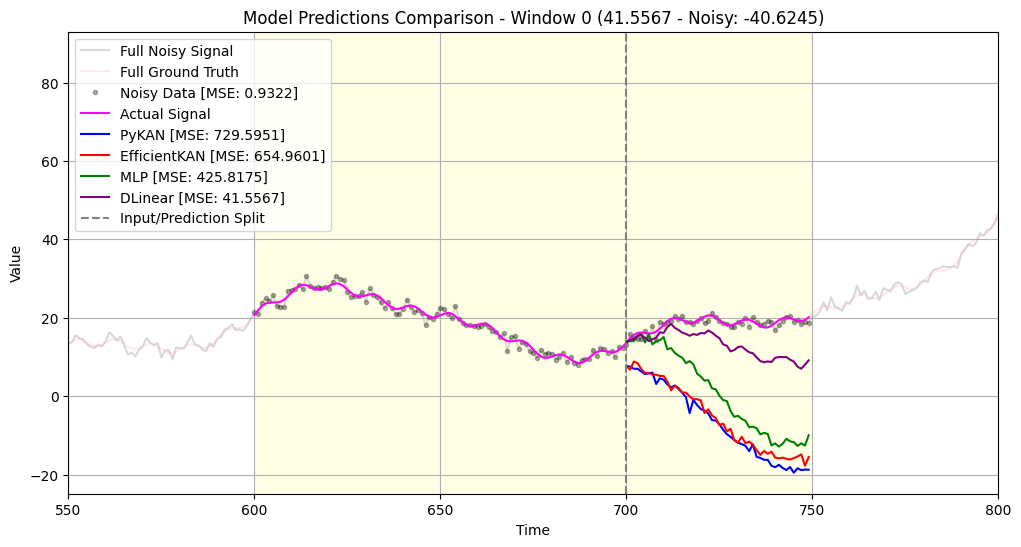

In [28]:
# Visualization parameters
window_idx = 0  # Which sliding window to show (0 is first window, 1 is second, etc.)
total_window_len = seq_len + pred_len

# Calculate window boundaries
window_start = train_size - seq_len + window_idx
window_end = window_start + total_window_len

plt.figure(figsize=(12, 6))

# Plot entire signal in light gray for context
plt.plot(noisy_signal, color='gray', alpha=0.3, label='Full Noisy Signal')
plt.plot(actual_signal, color='lightpink', alpha=0.3, label='Full Ground Truth')

# Plot the focused window
focused_noisy = noisy_signal[window_start:window_end]
focused_truth = actual_signal[window_start:window_end]

plt.plot(range(window_start, window_end), focused_noisy, 'k.', alpha=0.3, label=f'Noisy Data [MSE: {round(noisy_mse.item(), 4)}]')
# plt.plot(range(window_start, window_end), focused_noisy, color='black', alpha=1, label=f'Noisy Signal [MSE: {round(noisy_mse.item(), 4)}]')
plt.plot(range(window_start, window_end), focused_truth,
         color='magenta', label='Actual Signal')

# Plot predictions for all models
pred_start = window_start + seq_len
pred_end = pred_start + pred_len
for pred, name, color, mse in zip(predictions, model_names, model_colors, mse_scores):
    plt.plot(range(pred_start, pred_end),
             pred.squeeze().numpy(), color=color,
             label=f'{name} [MSE: {round(mse, 4)}]')

# Add vertical lines to show sequence/prediction boundary
plt.axvline(x=pred_start, color='gray', linestyle='--', 
            label='Input/Prediction Split')

# Highlight the window region
plt.axvspan(window_start, window_end, color='yellow', alpha=0.1)

# Set plot limits to focus on the window with some context
context = 50  # How many points to show before/after window
plt.xlim(window_start - context, window_end + context)

best_mse = min(mse_scores)
difference = noisy_mse.item() - best_mse

plt.title(f'Model Predictions Comparison - Window {window_idx} ({best_mse:.4f} - Noisy: {round(difference, 4)})')
plt.ylabel('Value')
plt.xlabel('Time')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Print comparison table
print("\nModel Performance Comparison:")
print("-" * 50)
print(f"{'Model':<15} {'MSE':>10} {'Difference':>15}")
print("-" * 50)
for name, mse in zip(model_names, mse_scores):
    difference = noisy_mse.item() - mse
    print(f"{name:<15} {mse:>10.4f} {difference:>15.4f}")


Model Performance Comparison:
--------------------------------------------------
Model                  MSE      Difference
--------------------------------------------------
PyKAN             729.5951       -728.6629
EfficientKAN      654.9601       -654.0279
MLP               425.8175       -424.8853
DLinear            41.5567        -40.6245


KeyboardInterrupt: 

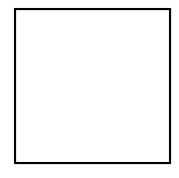

In [30]:
# Visualize the model structure
pykan.plot(scale=1)

In [ ]:
# First make the model symbolic
pykan.auto_symbolic()

# Then get and display the symbolic formula 
from kan.utils import ex_round
formula = ex_round(pykan.symbolic_formula()[0][0], 4)
formula

fixing (0,0,0) with x, r2=1.0000007152557373, c=1
fixing (0,0,1) with x, r2=1.0000004768371582, c=1
fixing (0,0,2) with x, r2=1.0000004768371582, c=1
fixing (0,0,3) with x, r2=1.0000005960464478, c=1
fixing (0,0,4) with x, r2=1.0000005960464478, c=1
fixing (0,0,5) with x, r2=1.0000005960464478, c=1
fixing (0,0,6) with x, r2=1.0000005960464478, c=1
fixing (0,0,7) with x, r2=1.0000005960464478, c=1
fixing (0,0,8) with x, r2=1.0000007152557373, c=1
fixing (0,0,9) with x, r2=1.0000004768371582, c=1
fixing (0,0,10) with x, r2=1.0000004768371582, c=1
fixing (0,0,11) with x, r2=1.0000005960464478, c=1
fixing (0,0,12) with x, r2=1.0000007152557373, c=1
fixing (0,0,13) with x, r2=1.0000004768371582, c=1
fixing (0,0,14) with x, r2=1.0000005960464478, c=1
fixing (0,0,15) with x, r2=1.0000005960464478, c=1
fixing (0,0,16) with x, r2=1.0000005960464478, c=1
fixing (0,0,17) with x, r2=1.0000005960464478, c=1
fixing (0,0,18) with x, r2=1.0000004768371582, c=1
fixing (0,0,19) with x, r2=1.000000476837

0.9773*x_1 + 0.2514 + 0.1055*exp(-0.2851*x_1) + 0.0651*exp(-0.2635*x_1) + 0.4716*exp(-0.2105*x_1) + 0.2341*exp(-0.2028*x_1) + 0.3197*exp(-0.1888*x_1)

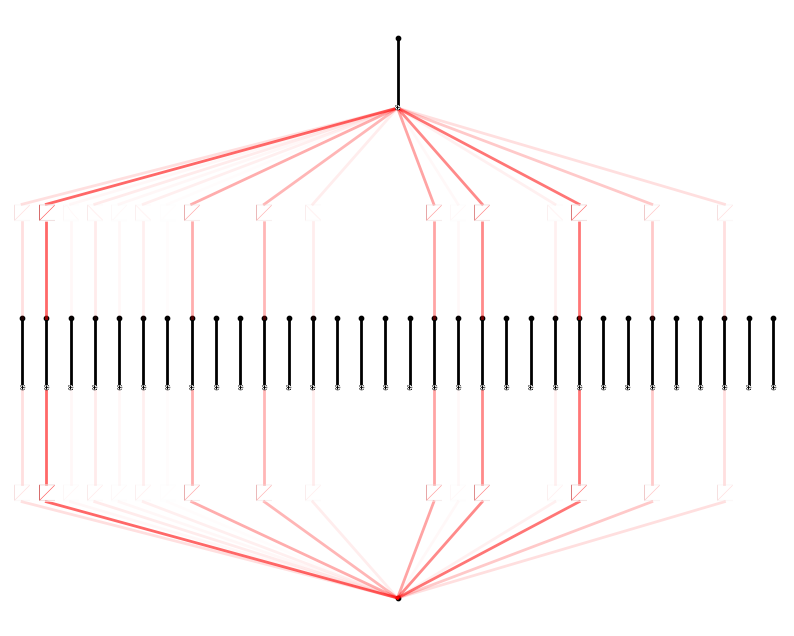

In [ ]:
pykan.plot(scale=1)

- Red edges represent purely symbolic functions
- Black edges represent purely numerical approximations
- Purple edges represent a combination of both
- White/transparent edges represent inactive connections